[70.0, 20.0, 15.0, 1.0, 0.0, 0.0, 0.0][70.0, 20.0, 15.0, 1.0, 0.0, 0.0, 0.0][70.0, 20.0, 15.0, 1.0, 0.0, 0.0, 0.0][69.99999895691872, 20.0, 15.0, 1.0, 0.0, 0.0, 0.0][70.0, 19.999999701976776, 15.0, 1.0, 0.0, 0.0, 0.0][70.0, 20.0, 14.999999776482582, 1.0, 0.0, 0.0, 0.0][70.0, 20.0, 15.0, 0.9999999850988388, 0.0, 0.0, 0.0][70.0, 20.0, 15.0, 1.0, -1.4901161193847656e-8, 0.0, 0.0][70.0, 20.0, 15.0, 1.0, 0.0, -1.4901161193847656e-8, 0.0][70.0, 20.0, 15.0, 1.0, 0.0, 0.0, -1.4901161193847656e-8][70.0, 20.0, 15.0, 1.0, 0.0, 0.0, 0.0][70.0, 20.0, 15.0, 1.0, 0.0, 0.0, 0.0][70.0, -3.185611668574386, -31.34253008902542, 1.0286534537332006, 0.0, 46.34253008902629, 92.6563669299241][70.0, -1.9973569344341726, -28.977237734705355, 1.0174564869337792, 0.0, 43.97723773470579, 87.93699933524606][70.0, 73.20329990178831, 121.47729402566864, 1.0706116614846324, 0.0, -106.47729402566691, -213.02528227343643][70.0, 3.6405223975799434, -17.789753383116746, 0.9291832403943563, 0.0, 32.78975338311716, 65.65030

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\jelte\.julia\packages\SciMLBase\Dwomw\src\integrator_interface.jl:626


NaN, NaN][NaN, NaN, NaN, NaN, NaN, NaN, NaN][NaN, NaN, NaN, NaN, NaN, NaN, NaN][NaN, NaN, NaN, NaN, NaN, NaN, NaN][NaN, NaN, NaN, NaN, NaN, NaN, NaN]

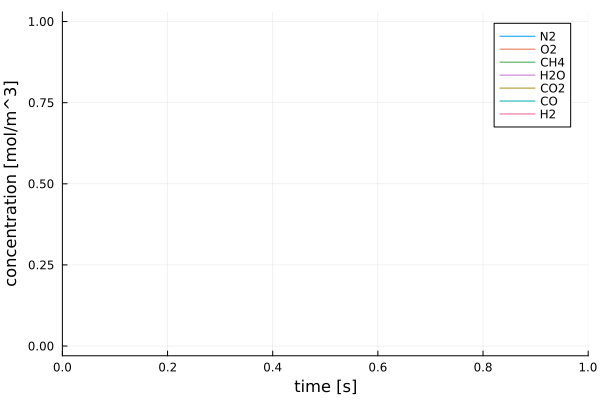

In [60]:
using DifferentialEquations
using Plots
using LinearAlgebra

# Temperature (assumed constant)
T = 1200 # K

# Initial species concentrations: N2, O2, CH4, H2O, CO2, CO, H2
X0 = [70.0, 20.0, 15.0, 1.0, 0.0, 0.0, 0.0] # mol/m^3

# Stoichiometric matrix
S = [0 -0.5 -1 0 0 1 2; 
     0 0 -1 -1 0 1 3; 
     0 -0.5 0 1 0 0 -1; 
     0 0.5 0 -1 0 0 1; 
     0 0 0 -1 1 -1 1; 
     0 0 0 1 -1 1 -1]

# Reaction rate function
function Arrhenius(T, X)
    R = 1987.204258640
    k  = zeros(6)
    k[1] = 0.44e12 * exp(-30000 / (R * T))
    k[2] = 0.30e9 * exp(-30000 / (R * T))
    k[3] = 0.25e17 * T^-1 * exp(-40000 / (R * T))
    k[4] = 0
    k[5] = 0.275e10 * exp(-20000 / (R * T))
    k[6] = 0

    # Ensure non-negative concentrations
    X = max.(X, 0)

    # Reaction rates
    r = zeros(6)
    r[1] = k[1] * X[3]^0.5 * X[2]^1.25
    r[2] = k[2] * X[3] * X[4]
    r[3] = k[3] * X[7]^0.5 * X[2]^2.25 * X[4]^-1
    r[4] = 0
    r[5] = k[5] * X[5] * X[4]
    r[6] = 0
    return r
end

# Differential equations function
function f!(dX, X, p, t)
    r = Arrhenius(T, X)
    dX .= S' * r
    print(X)
end

# Define time span
tend = 5e-10
tspan = (0.0, tend)

# Define ODE problem
problem = ODEProblem(f!, X0, tspan)

# Solve ODE problem with a stiff solver
sol = solve(problem, alg_hints=[:stiff])

# Plot solution
plot1 = plot(sol, xlabel = "time [s]", ylabel = "concentration [mol/m^3]", label = ["N2" "O2" "CH4" "H2O" "CO2" "CO" "H2"])
plot(plot1, legend = true)
